In [233]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
from pywaffle import Waffle


# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid.inset_locator import InsetPosition
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set(rc={
'axes.facecolor': '#FFF9ED', 
'figure.facecolor': '#FFF9ED'
})



In [234]:
from matplotlib.colors import ListedColormap
color=['#364BA5', '#EE1E14']
custom = sns.set_palette(sns.color_palette(color))
my_cmap = ListedColormap(sns.color_palette(color).as_hex())


In [235]:
df = pd.read_csv('Churn_Modelling.csv')
df.drop('RowNumber', axis=1, inplace=True)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


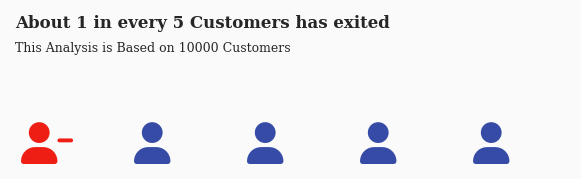

In [236]:
# Check the distribution of the data
background_color = '#fafafa'
# pywaffle library
data = {'left': 1, 'Stayed': 4}
fig = plt.figure(
    figsize=(4,2),
    dpi=150,
    facecolor=  background_color,
    FigureClass = Waffle,
    rows = 1,
    values = data,
    colors = [ '#EE1E14', '#364BA5'],
    legend = {'loc': 2, 'bbox_to_anchor': (1,1)},
    icons =  ['user-minus', 'user'],
    font_size = 20,
    vertical = True

    )
fig.text(0.035, 0.78, 'About 1 in every 5 Customers has exited', fontfamily='serif',
 fontsize = 8, fontweight = 'bold')
fig.text(0.035, 0.70, 'This Analysis is Based on 10000 Customers', fontfamily='serif',
fontsize = 6)
fig.gca().get_legend().remove()
fig.tight_layout()
plt.savefig('img/distribution.png')
plt.show()

# Exploratory Data Analysis and Visualization

The y variable is highly imbalanced. The number of customers that did not exit are ~80% while the ones that did are about 20%. This was expected given that it would be highly unlikely for a company to lose the same number of customers as it was keeping. <br>
The goal of this project is to create a machine learning model that predicts the customers that are likely to churn and therefore deal with their respective issues before they do so. <br>
The data being highly imbalanced will cause us problems in terms of recall and precision metrics. Therefore we will apply balancing techniques to the data before any machine learning model is fitted. However, we will start by exploring and cleaning our data.

We will drop additional columns 'customerId' and 'Surname' as I do not think they will be significant to our model

In [237]:
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)

In [238]:
# Binning the credit score column
"""
300-579: Poor.
580-669: Fair.
670-739: Good.
740-799: Very good.
800-850: Excellent.
"""

cut_labels = ['Poor', 'Fair', 'Good', 'Very_Good', 'Excellent']
cut_bins = [300, 579, 669, 739, 799, 850]
df['CreditScore_bins'] = pd.cut(df['CreditScore'], bins = cut_bins, labels=cut_labels)


# Binning the age column
"""
18-25: Youth
26-40: Young Adults
41-64: Older Adults
65-100: Seniors

"""
cut_labels = ['Youth', 'Young_Adults', 'Older_Adults', 'Seniors']
cut_bins = [18, 25, 40, 64, 100]
df['Age_bins'] = pd.cut(df['Age'], bins = cut_bins, labels=cut_labels)


## Balance
The Balance column has values that range from 0 to 250898 shillings.

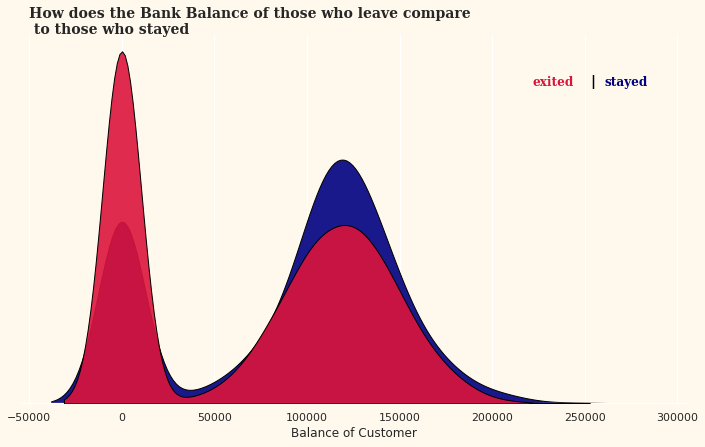

In [239]:
fig, axs = plt.subplots(1,1, figsize=(10,6))
axs.tick_params(axis='y', left=False)
axs.get_yaxis().set_visible(False)
for s in ['top', 'right', 'left']:
    axs.spines[s].set_visible(False)

y = df[df['Exited'] == 1]
n = df[df['Exited'] == 0]

sns.kdeplot(n['Balance'], ax = axs, color='crimson', shade=True, linewidth=1, ec='black',
alpha=0.9, zorder=3, legend=False)
sns.kdeplot(y['Balance'], ax = axs, color='navy', shade=True, linewidth=1, ec='black',
alpha=0.9, zorder=2, legend=False)

axs.set_xlabel('Balance of Customer', fontsize=12)

fig.text(0.05, 0.97, 'How does the Bank Balance of those who leave compare \n to those who stayed',
fontsize=14, fontweight='bold', fontfamily='serif')
fig.text(0.75, 0.85, 'exited', fontweight='bold', fontsize=12, color='crimson', fontfamily='serif')
fig.text(0.83, 0.85, '|', fontweight='bold', fontsize=14, color='black')
fig.text(0.85, 0.85, 'stayed', fontweight='bold', fontsize=12, color='navy', fontfamily='serif')

# fig.text(1.1, 0.80, 'Insight', fontsize=14, fontweight='bold',fontfamily='serif')
# fig.text(1.1, 0.45, 
# """
# The data appears to have a bimodal distribution. This reveals 
# to us that there are two different types of individuals represented 
# in the data. 
# * There is the first group with no balance in their accounts. This 
#   group has a higher proportion of people who stayed.
# * This second group represents individuals with a significant bank
#   balance in their account(100000 < x < 200000). This group has a higher
#   proportion of people leaving. Could it be that the bank is not satisfying
#   the needs of customers with high balances?
# """,
# fontsize=12, fontweight='light',fontfamily='serif'
# )
# l1 = lines.Line2D([1,1], [0,1], transform=fig.transFigure, figure=fig, color='black', lw=0.2)
# fig.lines.extend([l1])
# axs.tick_params(axis='both', which='major', labelsize=12)
# axs.tick_params(axis=u'both', which=u'both', length=0)


plt.tight_layout()
plt.savefig('img/Balance.png', bbox_inches='tight')
plt.show()

## Analysis of Bank Customers

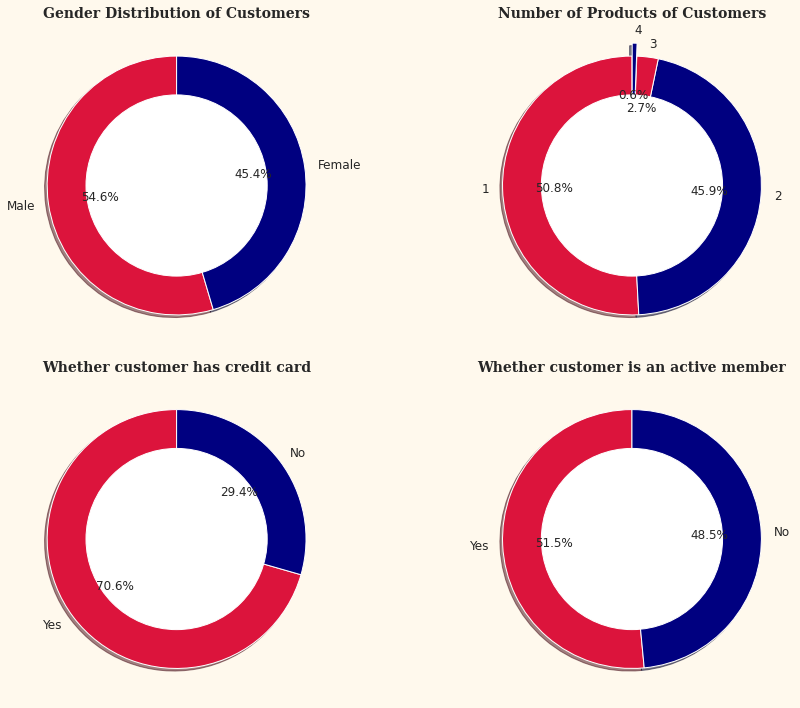

In [240]:
def donut_plot(df, col, title=None, ax=None, color=['crimson','navy'], labels = None, explode =None):
    data = df[col].value_counts()
    if labels is None:
        labels = data.index
    ax.pie(data, colors=color, autopct='%1.1f%%', shadow=True,
             startangle=90, labels=labels, textprops={'fontsize': 12},explode=explode)
    circle = plt.Circle((0,0), 0.7, color='white')
    ax.add_artist(circle)

    ax.set_title(title, fontsize=14, fontweight='bold', fontfamily='serif')
    plt.tight_layout()


fig, axs = plt.subplots(2,2, figsize=(24,10))


donut_plot(df, 'Gender', title='Gender Distribution of Customers', ax=axs[0,0])
donut_plot(df, 'NumOfProducts', title='Number of Products of Customers', ax=axs[0,1],
            explode=[0,0,0,0.1])
donut_plot(df, 'HasCrCard', title='Whether customer has credit card', ax=axs[1,0],
            labels = ['Yes', 'No'])
donut_plot(df, 'IsActiveMember', title='Whether customer is an active member', ax=axs[1,1],
            labels=['Yes', 'No'])
# plt.gcf().set_size_inches(15,10)
plt.tight_layout()




## How does the age of customers compare to their credit scores

Text(0.5, 0.98, 'Scatterplot on Age vs Credit Score')

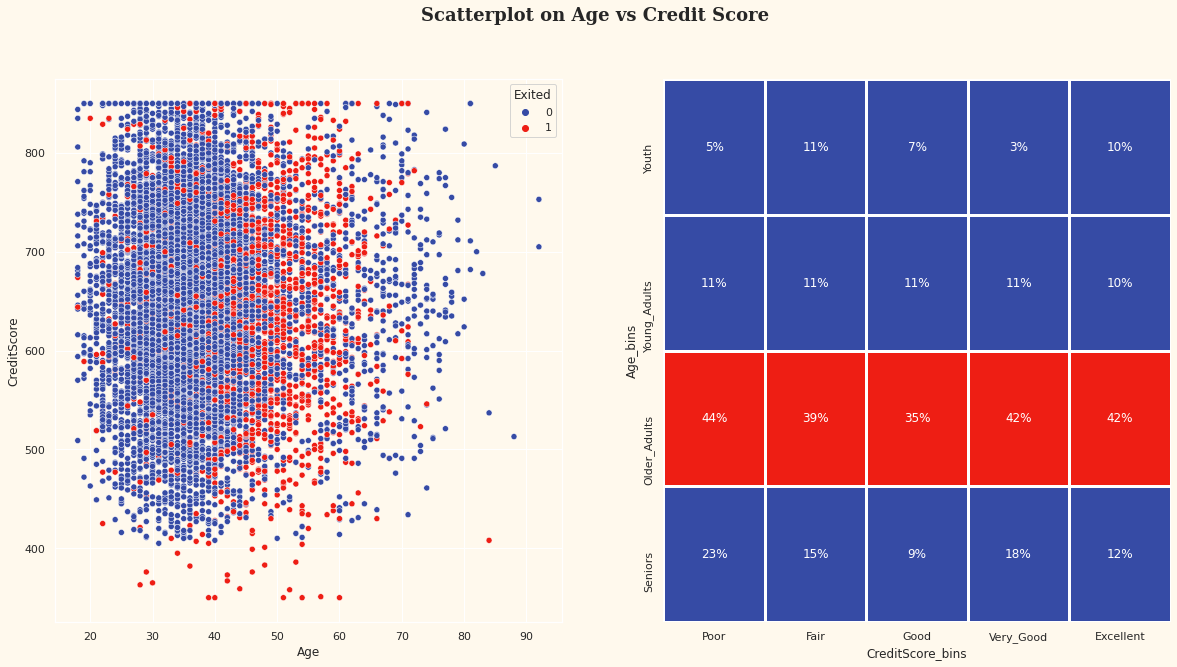

In [241]:
fig, axs = plt.subplots(1,2, figsize=(20,10))


# Create a scatterplot on age vs creditscore
sns.scatterplot(x='Age', y='CreditScore', data=df, hue='Exited', ax=axs[0], palette=custom)
df_heatmap = df.pivot_table(values='Exited', index='Age_bins', columns='CreditScore_bins', aggfunc=np.mean)
sns.heatmap(df_heatmap,  square=False, linewidth=2.5, cbar=False, annot=True, cmap = my_cmap,
            fmt='1.0%',vmax=.6, vmin=0.05,  annot_kws={'fontsize': 12}, ax=axs[1])
plt.suptitle('Scatterplot on Age vs Credit Score', fontsize=18, fontweight='bold', fontfamily='serif')



## Location and gender of the exited customers

Text(0.5, 1.0, 'Location and Gender of Exited Customers')

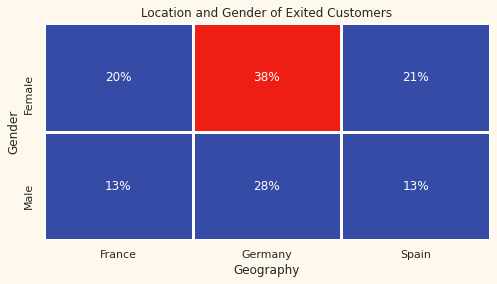

In [242]:
df_heatmap = df.pivot_table(values='Exited', index='Gender', columns='Geography', aggfunc=np.mean)
fig, axs = plt.subplots(1,1, figsize=(8,4))
sns.heatmap(df_heatmap,  square=False, linewidth=2.5, cbar=False, annot=True, cmap=my_cmap,
            fmt='1.0%',vmax=.6, vmin=0.05, ax=axs, annot_kws={'fontsize': 12})
plt.title('Location and Gender of Exited Customers')

Text(0.5, 0.98, 'Credit card usage by age')

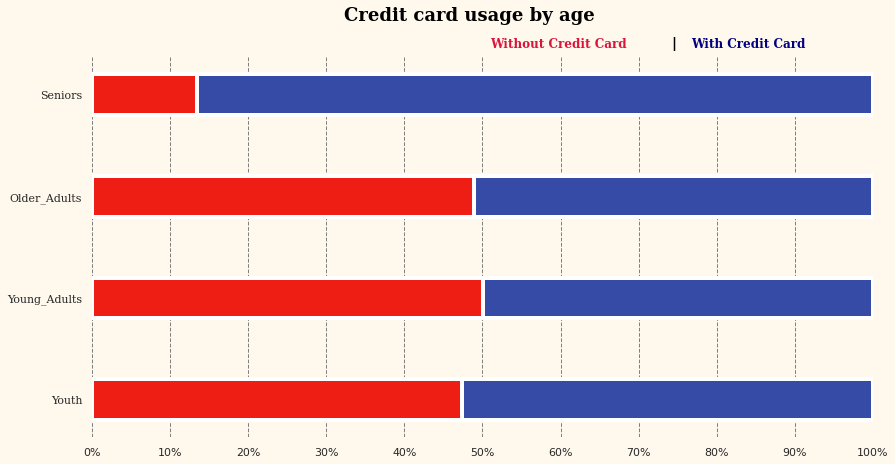

In [285]:
cross_tab_prop = pd.crosstab(
    index = df['Age_bins'],
    columns = df['IsActiveMember'], 
    normalize='index'
).sort_index(ascending=True)
labels = df['Age_bins'].tolist()
colors = [ '#EE1E14', '#364BA5']
title='Credit card usage by age'
fields = cross_tab.columns.tolist()

fig, ax = plt.subplots(1,1, figsize=(14,7))

# Plot bars
left = len(cross_tab) * [0]

for idx, name in enumerate(fields):
    plt.barh(cross_tab_prop.index,
     cross_tab_prop[name],
      left = left, 
      height=0.4,
      linewidth =4,
      align = 'center',
      color=colors[idx])
    left = left + cross_tab_prop[name]

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(cross_tab_prop.index, fontfamily='serif', fontsize=11)
# # remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# format x ticks
xticks = np.arange(0,1.1,0.1)
xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
plt.xticks(xticks, xlabels)
ax.xaxis.grid(color='gray', linestyle='dashed')

fig.text(0.52, 0.90, 'Without Credit Card', fontweight='bold', fontsize=12, color='crimson', fontfamily='serif')
fig.text(0.70, 0.90, '|', fontweight='bold', fontsize=14, color='black')
fig.text(0.72, 0.90, 'With Credit Card', fontweight='bold', fontsize=12, color='navy', fontfamily='serif')
plt.suptitle(title, fontweight='bold', fontsize=18, color='black', fontfamily='serif')

IsActiveMember,0,1
Age_bins,,
Youth,0.473684,0.526316
Young_Adults,0.501033,0.498967
Older_Adults,0.488936,0.511064
Seniors,0.134752,0.865248
